In [1]:
using UnboundedBNN, JLD2, Plots, Suppressor
using UnboundedBNN: TransformedDistribution, get_μ, get_σ

In [2]:
ω_range = 1:20

1:20

In [3]:
m, v = zeros(length(ω_range)), zeros(length(ω_range))
acc = zeros(length(ω_range))
for (ind, ω) in enumerate(ω_range)
    @suppress begin
        model = load("data/spiral/dim_4_omega_$ω.jld2")["model"]
        m[ind] = get_μ(model.posterior.dist)
        v[ind] = get_σ(model.posterior.dist)^2
        acc[ind] = load("data/spiral/dim_4_omega_$ω.jld2")["results/accuracy_test"]
    end
end

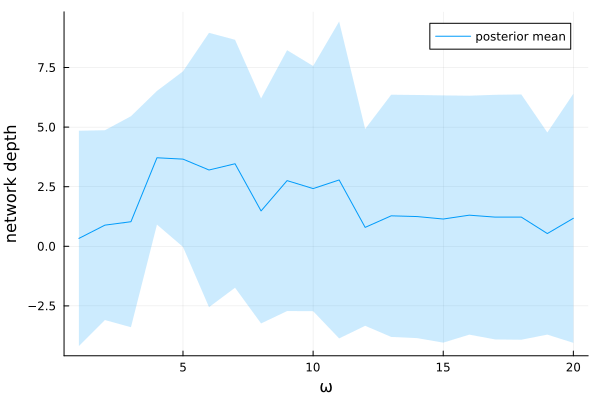

In [4]:
plot(ω_range, m, ribbon=v, fillalpha=0.2, label="posterior mean", xlabel="ω", ylabel="network depth")

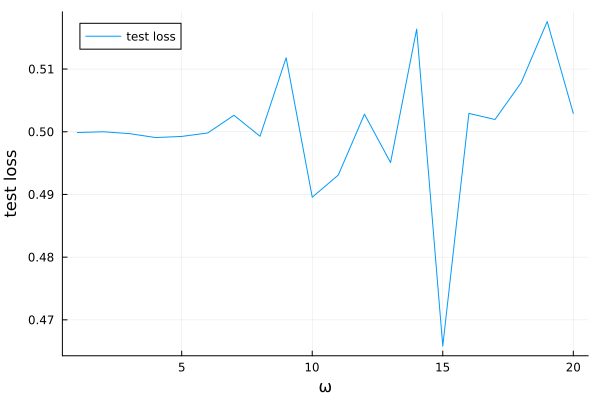

In [5]:
plot(ω_range, acc, label="test loss", xlabel="ω", ylabel="test loss")